### IMPORT LIBRARIES

In [44]:
#import the required libraries
import keras
from keras.layers import Embedding
from keras.layers import Dense, Flatten, LSTM
from keras.layers import Input, GlobalMaxPool1D, Dropout
from keras.layers import Activation
from keras.models import Model, Sequential

import os
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
#checking for the available gpu
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6008275512728076915
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4950209331
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11155609329136859541
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### LOAD THE DATA

In [46]:
#read the data files
train = pd.read_csv('F:/datasets/TOXIC COMMENT CLASSIFICATION/train.csv')
test = pd.read_csv('F:/datasets/TOXIC COMMENT CLASSIFICATION/test.csv')

In [47]:
#lets look at the data
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [48]:
#looking at the unique values in our output classes
print(train['toxic'].unique())
print(train['severe_toxic'].unique())
print(train['obscene'].unique())
print(train['threat'].unique())
print(train['insult'].unique())
print(train['identity_hate'].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


Let's break down our input features and the output labels that we have to predict

1. Our input features which will be our inputs to our DNN architecture will be the column consisting of the comments text.

2. As our input features are in the form of a text and not in the form of numbers and integers which is usually prefferd by the ML algorithms we will have to find a way to convert the raw text in the form of integers so that they can be fed to our model. (how to do this explained later)

3. Also the input texts are of different lengths. But our model expects the input sequences to have the same length. So we need to find a way to make all the lenght of input sequences equal.

4. Coming to our labels that we have to predict, we got in total six predictor classes. Depending on the input text we have to predict to which class our input text can be classified.

5. The values of our output labels are 0 and 1, corresponding to whether a particular statement can be classified in that class or not.


LET'S SEE FURTHER HOW TO SOLVE OUR PROBLEM

In [49]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


**As can be seen from the dataset, in the train dataset, our X training is the column have all the toxic comments and the remaining columns i.e ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', identity_hate'] are the Y labels which we have to predict**

In [50]:
#check for any null values in our dataset
print(train.isnull().any())

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool


In [51]:
#again checking for any null values in the test dataset
print(test.isnull().any())

id              False
comment_text    False
dtype: bool


In [52]:
#divide our training data into features X and label Y
X_train = train['comment_text'] #will be used to train our model on
X_test = test['comment_text'] #will be used to predict the output labels to see how well our model has trained
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [53]:
y_train.shape #as expected total 6 columns for 6 predictor classes

(159571, 6)

### PREPROCESSING USING KERAS

Preprocessing is the most important step when it comes to any of the dataset before it is passed to a Machine Learning model. This fact is no less true when it comes to dealing with text dataset.

Infact for text dataset preprocessing is a must and without which we cannot move forward in training our model.

The fact that our algorithm only understand numbers and integers and cannot understand strings or text data makes preprocessing even more valuable and essential in Natural Language Processing.

When it comes to preprocessing a text data the most common steps are:
1. The entire sentence needs to be converted in the form of small tokens or into individual words. By doing this it helps us to assign each word with a unique integer value called as index or ID of that word.


2. Tokenization also helps us to find the total number of unique words in our vocabulary which is later to be fed in our model.


3. Once the tokenization is done, the next common step is to remove stopwords. Stopwords are the the most commonly occuring words in our vocabulary. Words that won't generally matter even if they are taken out from our vocabulary. For example words like 'the', 'and', 'so', 'if' etc are the stopwords. But we don't always have to remove the stopwords. Stopwords are only removed when their absence won't affect our model prediction much, in cases like classification of documents according to the topics, stopwords can be removed as we only have to focus on words that carry more importance in our documents.


4. There are various other ways in which preprocessing of the text data can be done.

**KERAS** is a high level deep learning API which is also very easy when it comes to applying deep learning algorithms. Keras offers a 'Tokenizer' class which carries out tokenisation for us and also convert all the text data into lowercase

In [54]:
#import the tokenizer class from the keras api
from keras.preprocessing.text import Tokenizer

In [55]:
#let's calculate the vocabulary size as well which will be given as an input to the Embedding layer
tokens = Tokenizer() #tokenizes our data
tokens.fit_on_texts(X_train)
vocab_size = len(tokens.word_index) + 1 #size of the total number of uniques tokens in our dataset
tokenized_train = tokens.texts_to_sequences(X_train) #converting our tokens into sequence of integers
tokenized_test = tokens.texts_to_sequences(X_test)

In [56]:
print(tokenized_train[:2]) #the first comment 

[[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985], [96145, 52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]]


**1. Now if you observe the vector representation of each comment, the size of each vector is different.**

**2. But our machine learning model expects the size of our input data to be same throughout.**

**3. Hence we will be doing padding**

In [57]:
#import the pad_sequences class from the keras api
from keras.preprocessing.sequence import pad_sequences

In [58]:
max_len = 300 #maximum length of the padded sequence that we want (one of the hyperparameter that can be tuned)
padded_train = pad_sequences(tokenized_train, maxlen = max_len, padding = 'post') #post padding our sequences with zeros
padded_test = pad_sequences(tokenized_test, maxlen = max_len)

In [59]:
padded_train[:10] #as you can observe once our sentence ends the padding starts and continues until we have a vector of max_len

array([[  688,    75,     1, ...,     0,     0,     0],
       [96145,    52,  2635, ...,     0,     0,     0],
       [  412,   437,    73, ...,     0,     0,     0],
       ...,
       [   20,   199,     2, ...,     0,     0,     0],
       [  263,    22,     1, ...,     0,     0,     0],
       [10960,    15,    13, ...,     0,     0,     0]])

### BUILD THE MODEL USING SEQUENTIAL API

KERAS provides two API's in order to build a deep learning model

**1. Sequential API**

**2. Functional API**

we will build our model using both the API's

The structure of our model will be as follows:

1. We will create an instance of the Sequential API.

2. We will add an Embedding layer as our first layer of the model. Now Embedding layer maps our input sequences in an Embedding space. Our input sequences are nothing but vectors representing each unique word in our vocabulary. So each point in the Embedding space represents the position of that word with it's vector representation.

3. The Embedding layer requires three parameters to be sepcified. The first is the input_dim which is nothing but the size of our vocabulary. The second parameter is the output_dim which represents the Embedding space dimension that we want (can be tuned). The third one is the input_length which is the input maximum sequence length of our input vectors.

4. The layer which is to be added on the top of the Embedding layer is the LSTM layer. The first parameter which is to be specified is the number of nodel in LSTM layer.

5. We can also tweak with the activation function that we want to apply on our LSTM layer.

6. Next we will convert our 2-dimensional matrix representation into a 1 dimensional vector so that it can be fed to the fully connected layer.

7. Next we will add a fully connected layer with number of neurons to be specified along with the activation function.

8. And lastly we will add another fully connected layer which will be our output layer. This layer will have in total 6 nodes corresponding to each classification label that we want to classify our input text into.

In [29]:
model = Sequential() #instatiating the sequential API
model.add(Embedding(input_dim = vocab_size, output_dim = 150, input_length = max_len))
model.add(LSTM(60, return_sequences = True))
model.add(Activation('relu'))
#model.add(LSTM(120, return_sequences = True))
#model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(6, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 150)          31550700  
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 60)           50640     
_________________________________________________________________
activation_2 (Activation)    (None, 300, 60)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1800100   
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 606       
Total params: 33,402,046
Trainable params: 33,402,046
Non-trainable params: 0
________________________________________________________________

In [30]:
#compile the model
model.compile(optimizer = 'ADAM', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
#fit the model
history = model.fit(padded_train, y_train, epochs = 5, batch_size = 64)

Epoch 1/5
159571/159571 [==============================] - 1134s 7ms/step - loss: 0.2174 - acc: 0.9662
Epoch 2/5
159571/159571 [==============================] - 1136s 7ms/step - loss: 0.2129 - acc: 0.9680
Epoch 3/5
159571/159571 [==============================] - 1139s 7ms/step - loss: 0.2090 - acc: 0.9696
Epoch 4/5
159571/159571 [==============================] - 1138s 7ms/step - loss: 0.2061 - acc: 0.9706
Epoch 5/5
159571/159571 [==============================] - 1085s 7ms/step - loss: 0.2041 - acc: 0.9715


### LSTM MODEL USING FUNCTIONAL API

While building our model using the functional API we have used some new layers in our network

1. Starting few layers are same as the previous, the layer called Dropout is been added here. Now Dropout is a regularisation technique which we implement to prevent out model from overfitting to our training data. This technique randomly drops (or switches off) nodes from a particular layer with the given probability. So that the input and output both are blocked for the node which is been dropped.

2. Here we have stacked two **(LSTM-->Activation-->GlobalMaxPool1D-->Dropout)** onto each other followed by few fully connected layers and finally another fully connected layer with 6 neurons as the output layer of our model.

In [20]:
input_model = Input(shape = (max_len, ))
x = Embedding(input_dim = vocab_size, output_dim = 120)(input_model)
x = LSTM(60, return_sequences = True)(x)
x = Activation('relu')(x)
#x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)

x = LSTM(100, return_sequences = True)(x)
x = Activation('relu')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)

x = Dense(150, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(100, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation = 'sigmoid')(x)

In [21]:
model_1 = Model(inputs = input_model, outputs = x)
model_1.compile(loss = 'binary_crossentropy', optimizer = 'ADAM', metrics = ['accuracy'])

In [22]:
#check the number of parameters in our model
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 120)          25240560  
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 60)           43440     
_________________________________________________________________
activation_1 (Activation)    (None, 300, 60)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 100)          64400     
_________________________________________________________________
activation_2 (Activation)    (None, 300, 100)          0         
__________

In [23]:
history_1 = model_1.fit(padded_train, y_train, batch_size = 64, epochs = 5, validation_split = 0.3)

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 4134s 37ms/step - loss: 0.0950 - acc: 0.9696 - val_loss: 0.0579 - val_acc: 0.9785
Epoch 2/5
111699/111699 [==============================] - 1671s 15ms/step - loss: 0.0523 - acc: 0.9811 - val_loss: 0.0511 - val_acc: 0.9811
Epoch 3/5
111699/111699 [==============================] - 1747s 16ms/step - loss: 0.0436 - acc: 0.9836 - val_loss: 0.0526 - val_acc: 0.9817
Epoch 4/5
111699/111699 [==============================] - 4662s 42ms/step - loss: 0.0384 - acc: 0.9854 - val_loss: 0.0537 - val_acc: 0.9811
Epoch 5/5
111699/111699 [==============================] - 2994s 27ms/step - loss: 0.0345 - acc: 0.9868 - val_loss: 0.0553 - val_acc: 0.9807


### PLOT THE ACCURACY AND LOSS CURVES

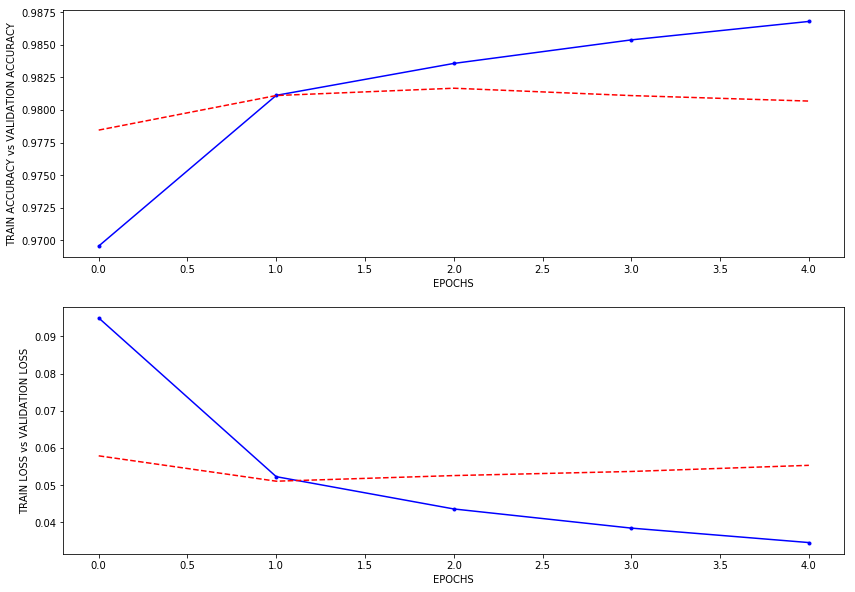

In [34]:
plt.figure(figsize = (14,10))
plt.subplot(2, 1, 1)
plt.plot(range(5), history_1.history['acc'], 'b.-')
plt.plot(range(5), history_1.history['val_acc'], 'r--')
plt.xlabel('EPOCHS')
plt.ylabel('TRAIN ACCURACY vs VALIDATION ACCURACY')

plt.subplot(2, 1, 2)
plt.plot(range(5), history_1.history['loss'], 'b.-')
plt.plot(range(5), history_1.history['val_loss'], 'r--')
plt.xlabel('EPOCHS')
plt.ylabel('TRAIN LOSS vs VALIDATION LOSS')

plt.show()

### SAVE THE WIEGHTS FOR THE MODEL

In [37]:
model_1.save('TTC_MODEL')
model_1.save_weights('MODEL1.h5')

### SAVING AND LOADING THE ENTIRE MODEL

In [42]:
# serialize model to YAML
model_yaml = model_1.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
print("Saved model to disk")

Saved model to disk


In [43]:
# serialize model to JSON
model_json = model_1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")

Saved model to disk


### USING PRE-TRAINED WORD EMBEDDINGS

Pre-trained word embeddings are the ones which are usually trained on a large amount of corpus. Using such pre-trained word embeddings on your model can help achieve the model very good amount of accuracy. Using pre-trained word embeddings helps you to avoid training your own word embedding from scratch. This method can be employed when the available amount of dataset is not too much. **Word2Vec(by google)** and **Glove(by stanford NLP group)** are the two most commonly use pre-trained word embeddings.

In [66]:
import numpy as np

embedding_dim = 50
#def create_embedding_matrix(filepath, embedding_dim):
vocab_size = len(tokens.word_index) + 1  # Adding again 1 because of reserved 0 index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

with open('F:/datasets/GLOVE PRETRAINED MODEL/glove.6B.50d.txt', encoding = 'utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in tokens.word_index:
            idx = tokens.word_index[word] 
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

In [69]:
model_2 = Sequential()
model_2.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable=False))
model_2.add(GlobalMaxPool1D())
model_2.add(Dropout(0.25))
model_2.add(Dense(10, activation = 'relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(6, activation = 'sigmoid'))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 50)           10516900  
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 66        
Total params: 10,517,476
Trainable params: 576
Non-trainable params: 10,516,900
______________________________________________________________

In [78]:
#compile the model
model_2.compile(optimizer = keras.optimizers.Adam(lr = 0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [79]:
#fit the model on the dataset
history_2 = model_2.fit(padded_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.3)

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 49s 442us/step - loss: 0.2989 - acc: 0.9942 - val_loss: 0.2986 - val_acc: 0.9940
Epoch 2/5
111699/111699 [==============================] - 51s 456us/step - loss: 0.2990 - acc: 0.9942 - val_loss: 0.2987 - val_acc: 0.9940: 0.297
Epoch 3/5
111699/111699 [==============================] - 56s 499us/step - loss: 0.2991 - acc: 0.9942 - val_loss: 0.2987 - val_acc: 0.9940
Epoch 4/5
111699/111699 [==============================] - 43s 387us/step - loss: 0.2988 - acc: 0.9942 - val_loss: 0.2987 - val_acc: 0.9940
Epoch 5/5
111699/111699 [==============================] - 44s 391us/step - loss: 0.2989 - acc: 0.9942 - val_loss: 0.2987 - val_acc: 0.9940


In [81]:
# serialize model to JSON
model_json = model_2.to_json()
with open("model_we.json", "w") as json_file:
    json_file.write(model_json)
model_2.save_weights('MODEL2_we.h5')
print("Saved model to disk")

Saved model to disk
